In [ ]:
import gzip
import tarfile
import pickle
import numpy as np
from google.colab.patches import cv2_imshow, cv2
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2023-05-24 05:19:22--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  53.5MB/s    in 3.2s    

2023-05-24 05:19:26 (50.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
!gzip -d cifar-10-python.tar.gz

In [ ]:
data_file = 'cifar-10-python.tar'
data_file_obj= tarfile.open(data_file,"r")

In [ ]:
file_list=data_file_obj.getnames()
for name in file_list:
    print(name)

cifar-10-batches-py
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
import os
file = data_file_obj.extractall("extracted_tar_folder")
batch_1 = '/content/extracted_tar_folder/cifar-10-batches-py/data_batch_1'
batch_2 = '/content/extracted_tar_folder/cifar-10-batches-py/data_batch_2'
batch_3 = '/content/extracted_tar_folder/cifar-10-batches-py/data_batch_3'
batch_4 = '/content/extracted_tar_folder/cifar-10-batches-py/data_batch_4'
batch_5 = '/content/extracted_tar_folder/cifar-10-batches-py/data_batch_5'
test_batch = '/content/extracted_tar_folder/cifar-10-batches-py/test_batch'

In [ ]:
with open(batch_1, 'rb') as fo:
  first_batch = pickle.load(fo, encoding='bytes')
with open(batch_2, 'rb') as fo:
  second_batch = pickle.load(fo, encoding='bytes')
with open(batch_3, 'rb') as fo:
  third_batch = pickle.load(fo, encoding='bytes')
with open(batch_4, 'rb') as fo:
  fourth_batch = pickle.load(fo, encoding='bytes')
with open(batch_5, 'rb') as fo:
  fifth_batch = pickle.load(fo, encoding='bytes')
with open(test_batch, 'rb') as fo:
  batch_test = pickle.load(fo, encoding='bytes')

print((first_batch[b'data'][0]))
print(second_batch[b'data'][0])

dataset_x = np.concatenate((first_batch[b'data'], second_batch[b'data'], third_batch[b'data'], fourth_batch[b'data'], fifth_batch[b'data']), axis = 0)
dataset_x = np.reshape(dataset_x, (-1, 32, 32, 3))
print(dataset_x.shape)

dataset_y = np.concatenate((np.array(first_batch[b'labels']), np.array(second_batch[b'labels']), np.array(third_batch[b'labels']), np.array(fourth_batch[b'labels']), np.array(fifth_batch[b'labels'])), axis = 0)
dataset_y = np.reshape(dataset_y, [-1, 1])


[ 59  43  50 ... 140  84  72]
[ 35  27  25 ... 169 168 168]
(50000, 32, 32, 3)


In [ ]:
np.random.seed(42)

sampled_x_train = []
sampled_y_train = []

for class_label in range(10):

    indices = np.where(dataset_y == class_label)[0]

    sampled_indices = np.random.choice(indices, size=1000, replace=False)

    sampled_x_train.append(dataset_x[sampled_indices])
    sampled_y_train.append(dataset_y[sampled_indices])

sampled_x_train = np.concatenate(sampled_x_train, axis=0)
sampled_y_train = np.concatenate(sampled_y_train, axis=0)

shuffle_indices = np.random.permutation(len(sampled_x_train))
sampled_x_train = sampled_x_train[shuffle_indices]
sampled_y_train = sampled_y_train[shuffle_indices]

print('Sampled Training Data Shape:', sampled_x_train.shape)
print('Sampled Training Labels Shape:', sampled_y_train.shape)

Sampled Training Data Shape: (10000, 32, 32, 3)
Sampled Training Labels Shape: (10000, 1)


#Question 1

Mounted at /content/drive


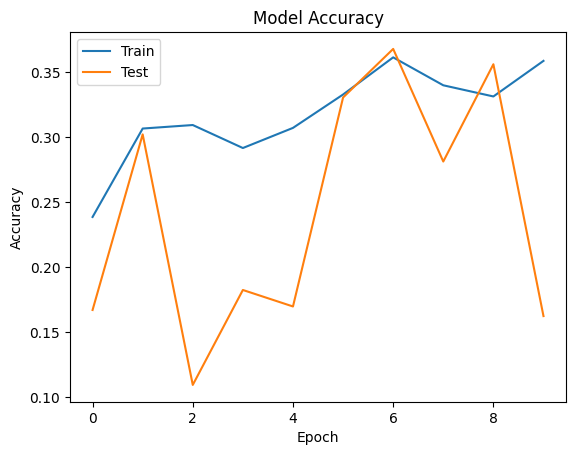

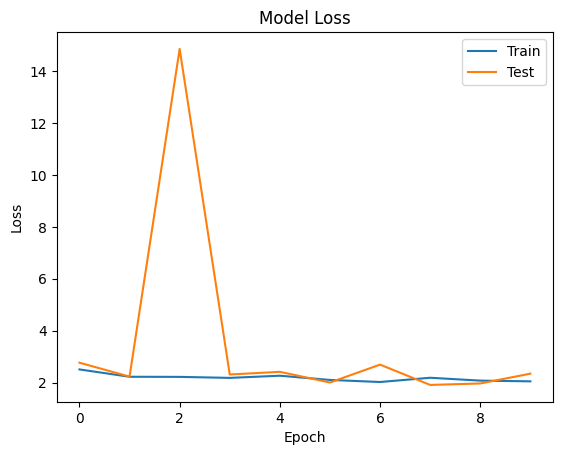

313/313 [==============================] - 53s 160ms/step - loss: 2.6967 - accuracy: 0.3680
Test Accuracy:0.368


In [ ]:
drive.mount('/content/drive', force_remount=True)

x_train, y_train = sampled_x_train, sampled_y_train
x_test, y_test = batch_test[b'data'], batch_test[b'labels']

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

x_test = np.reshape(x_test, (-1, 32, 32, 3))

checkpoint_filepath = '/content/drive/MyDrive/resnet_checkpoint/resnet_best_weights.h5'
history_filepath = '/content/drive/MyDrive/resnet_checkpoint/history.npy'

model = ResNet50(weights=None, input_shape=(32, 32, 3), classes=10)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the ModelCheckpoint callback to save the best weights
checkpoint_callback = ModelCheckpoint(checkpoint_filepath,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      mode='max',
                                      verbose=1)
history = None

if os.path.exists(checkpoint_filepath):
    model.load_weights(checkpoint_filepath)
    if os.path.exists(history_filepath):
      history = np.load(history_filepath, allow_pickle=True).item()

else:
    history = model.fit(x_train, y_train,
              batch_size=32,
              epochs=20,
              validation_data=(x_test, y_test),
              callbacks=[checkpoint_callback])

    np.save(history_filepath, history.history)

if history:
  import matplotlib.pyplot as plt
  #print(history)
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

_, test_accuracy = model.evaluate(x_test, y_test)
print('Test Accuracy:%.3f' %(test_accuracy))


#Question 2

In [ ]:
def mixup_augmentation(x1, y1, x2, y2, alpha):
    lam = np.random.beta(alpha, alpha)

    mixed_x = lam * x1 + (1 - lam) * x2
    mixed_y = lam * y1 + (1 - lam) * y2

    return mixed_x, mixed_y

# Load and preprocess the CIFAR10 dataset
x_train, y_train = sampled_x_train, sampled_y_train
x_test, y_test = batch_test[b'data'], batch_test[b'labels']

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_test = np.reshape(x_test, (-1, 32, 32, 3))

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Define the checkpoint filepath
checkpoint_dir = '/content/drive/MyDrive/resnet_checkpoint'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_filepath = os.path.join(checkpoint_dir, 'resnet_mixup_best_weights.h5')
history_filepath = os.path.join(checkpoint_dir, 'resnet_mixup_history.pkl')

# Check if the checkpoint file exists
if os.path.exists(checkpoint_filepath):
    # Create the ResNet50 model
    base_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 3))

    # Add a global average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a fully connected layer
    x = Dense(256, activation='relu')(x)

    # Add the output layer
    predictions = Dense(10, activation='softmax')(x)

    # Build the final model
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    # Load the best weights
    model.load_weights(checkpoint_filepath)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Evaluate the model on the test set
    _, test_accuracy = model.evaluate(x_test, y_test)
    print('Test Accuracy:', test_accuracy)

    # Load the history from the pickle file
    with open(history_filepath, 'rb') as f:
        history = pickle.load(f)

else:
    # Create the ResNet50 model
    base_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 3))

    # Add a global average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a fully connected layer
    x = Dense(256, activation='relu')(x)

    # Add the output layer
    predictions = Dense(10, activation='softmax')(x)

    # Build the final model
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Set the hyperparameters for Mixup augmentation
    alpha_values = [0.2, 0.4]

    # Training loop
    batch_size = 32
    num_epochs = 10
    history = {}

    for alpha in alpha_values:
        best_accuracy = 0
        print(f"\nMixup augmentation with alpha = {alpha}")
        history[alpha] = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")

            # Shuffle the training data
            indices = np.random.permutation(len(x_train))
            x_train_shuffled = x_train[indices]
            y_train_shuffled = y_train[indices]

            # Create mini-batches with mixup augmentation
            for i in range(0, len(x_train_shuffled), batch_size):
                x_batch = x_train_shuffled[i:i+batch_size]
                y_batch = y_train_shuffled[i:i+batch_size]

                # Generate random pairs for mixup augmentation
                indices = np.random.choice(len(x_train_shuffled), size=len(x_batch), replace=False)
                x_random = x_train_shuffled[indices]
                y_random = y_train_shuffled[indices]

                # Apply mixup augmentation to the mini-batch
                x_mixed, y_mixed = mixup_augmentation(x_batch, y_batch, x_random, y_random, alpha)

                # Train the model on the augmented mini-batch
                metrics = model.train_on_batch(x_mixed, y_mixed)

                # Update the training history
                history[alpha]['accuracy'].append(metrics[1])
                history[alpha]['loss'].append(metrics[0])

            # Evaluate the model on the test set
            _, test_accuracy = model.evaluate(x_test, y_test)
            print('Test Accuracy:', test_accuracy)

            # Append the validation metrics to history
            history[alpha]['val_accuracy'].append(test_accuracy)
            history[alpha]['val_loss'].append(model.evaluate(x_test, y_test, verbose=0)[0])

            # Save the best weights based on validation accuracy
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                model.save_weights(checkpoint_filepath)

        # Save the history to a pickle file
        with open(history_filepath, 'wb') as f:
            pickle.dump(history, f)

        print("Training and history saved successfully.")

if history:
    import matplotlib.pyplot as plt

    for alpha, data in history.items():
        # Plot accuracy
        plt.plot(data['accuracy'])
        plt.plot(data['val_accuracy'])
        plt.title(f'Model Accuracy (alpha={alpha})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        # Plot loss
        plt.plot(data['loss'])
        plt.plot(data['val_loss'])
        plt.title(f'Model Loss (alpha={alpha})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Test'], loc='upper right')
        plt.show()

313/313 [==============================] - 55s 168ms/step - loss: 1.6090 - accuracy: 0.4208
Test Accuracy: 0.42080000042915344


FileNotFoundError: ignored

#Question 3

Mounted at /content/drive
Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 2.5555 - accuracy: 0.2293
Epoch 1: val_accuracy improved from -inf to 0.13160, saving model to /content/drive/MyDrive/resnet_checkpoint/resnetCutoutBestWeights.h5
313/313 [==============================] - 949s 3s/step - loss: 2.5555 - accuracy: 0.2293 - val_loss: 2.6423 - val_accuracy: 0.1316
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 2.4349 - accuracy: 0.2682
Epoch 2: val_accuracy improved from 0.13160 to 0.26570, saving model to /content/drive/MyDrive/resnet_checkpoint/resnetCutoutBestWeights.h5
313/313 [==============================] - 910s 3s/step - loss: 2.4349 - accuracy: 0.2682 - val_loss: 33.5472 - val_accuracy: 0.2657
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 2.4516 - accuracy: 0.2314
Epoch 3: val_accuracy did not improve from 0.26570
313/313 [==============================] - 916s 3s/step - loss: 2.4516 - accuracy: 0.2314 - v

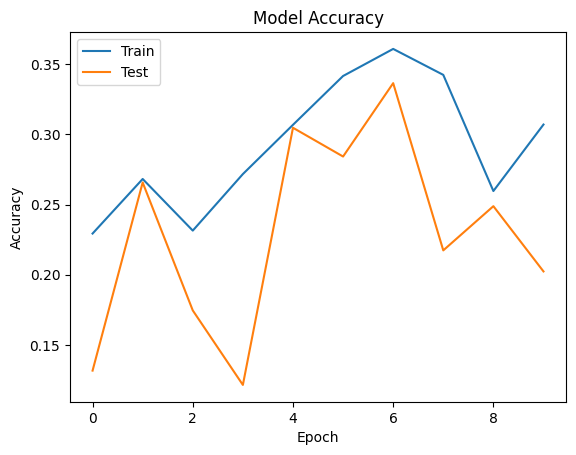

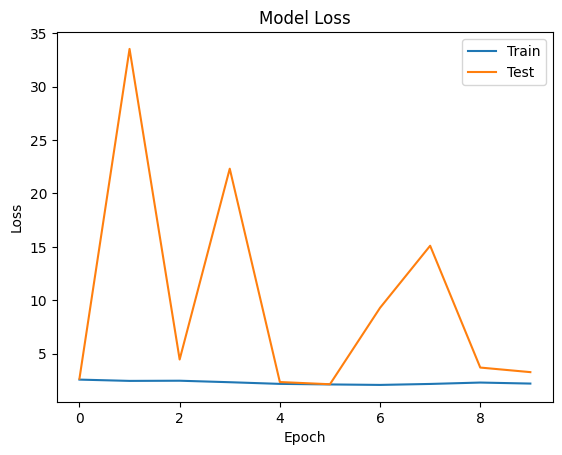

313/313 [==============================] - 50s 160ms/step - loss: 9.2840 - accuracy: 0.3365
Test Accuracy: 0.336


In [ ]:
def apply_cutout(image, mask_size):
    height, width, _ = image.shape

    mask_center_x = np.random.randint(0, width)
    mask_center_y = np.random.randint(0, height)

    mask_top = max(0, mask_center_y - mask_size // 2)
    mask_bottom = min(height, mask_center_y + mask_size // 2)
    mask_left = max(0, mask_center_x - mask_size // 2)
    mask_right = min(width, mask_center_x + mask_size // 2)

    image[mask_top:mask_bottom, mask_left:mask_right, :] = 0.0

    return image

drive.mount('/content/drive', force_remount=True)

X_Train, Y_Train = sampled_x_train, sampled_y_train
X_Test, Y_Test = batch_test[b'data'], batch_test[b'labels']

X_Train = X_Train.astype('float32') / 255.0
X_Test = X_Test.astype('float32') / 255.0

Y_Train = to_categorical(Y_Train, num_classes=10)
Y_Test = to_categorical(Y_Test, num_classes=10)

X_Test = np.reshape(X_Test, (-1, 32, 32, 3))

checkpointFile = '/content/drive/MyDrive/resnet_checkpoint/resnetCutoutBestWeights.h5'
historyFile = '/content/drive/MyDrive/resnet_checkpoint/histCutout.npy'

model = ResNet50(weights=None, input_shape=(32, 32, 3), classes=10)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointCallback = ModelCheckpoint(checkpointFile,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      mode='max',
                                      verbose=1)
history = None

if os.path.exists(checkpointFile):
    model.load_weights(checkpointFile)
    if os.path.exists(historyFile):
        history = np.load(historyFile, allow_pickle=True).item()

else:
    mask_size = 16
    for i in range(len(X_Train)):
        if np.random.rand() < 0.5:
            X_Train[i] = apply_cutout(X_Train[i], mask_size)

    history = model.fit(X_Train, Y_Train,
                        batch_size=32,
                        epochs=10,
                        validation_data=(X_Test, Y_Test),
                        callbacks=[checkpointCallback])

    np.save(historyFile, history.history)
    model.load_weights(checkpointFile)
    history = np.load(historyFile, allow_pickle=True).item()

if history:
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

_, testAccuracy = model.evaluate(X_Test, Y_Test)
print('Test Accuracy: %.3f' % testAccuracy)

#Question 4

Mounted at /content/drive
Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 2.5602 - accuracy: 0.2012
Epoch 1: val_accuracy improved from -inf to 0.13980, saving model to /content/drive/MyDrive/resnet_checkpoint/resnetStandardBestWeights.h5
313/313 [==============================] - 921s 3s/step - loss: 2.5602 - accuracy: 0.2012 - val_loss: 2.2746 - val_accuracy: 0.1398
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 2.3648 - accuracy: 0.2185
Epoch 2: val_accuracy improved from 0.13980 to 0.20830, saving model to /content/drive/MyDrive/resnet_checkpoint/resnetStandardBestWeights.h5
313/313 [==============================] - 901s 3s/step - loss: 2.3648 - accuracy: 0.2185 - val_loss: 3.8651 - val_accuracy: 0.2083
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 2.2932 - accuracy: 0.2653
Epoch 3: val_accuracy improved from 0.20830 to 0.21810, saving model to /content/drive/MyDrive/resnet_checkpoint/resnetStandardBestWeights.h5

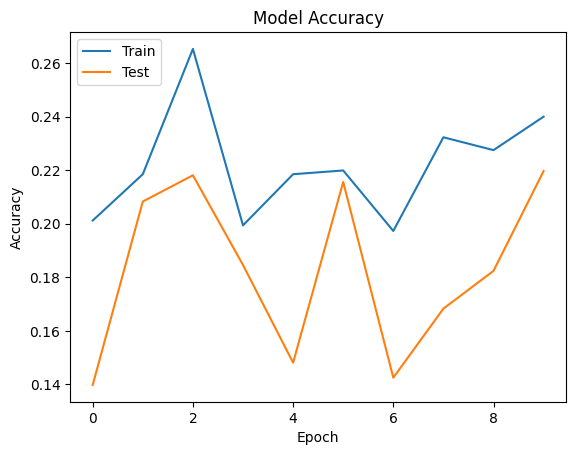

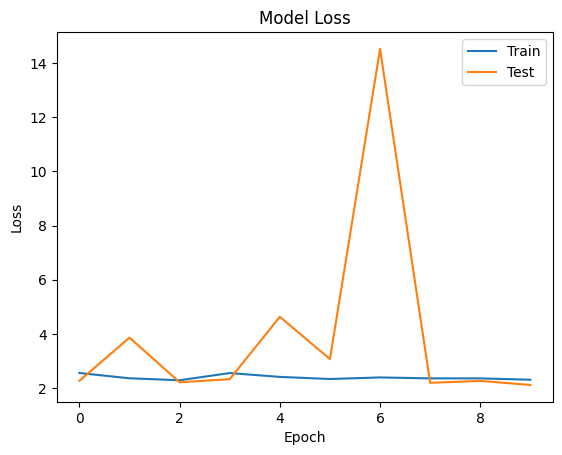

313/313 [==============================] - 49s 156ms/step - loss: 2.1207 - accuracy: 0.2197
Test Accuracy: 0.220


In [ ]:
def apply_standard_augmentation(image, K):
    height, width, _ = image.shape

    k1 = np.random.randint(-K, K + 1)
    k2 = np.random.randint(-K, K + 1)

    image = np.roll(image, k1, axis=0)
    image = np.roll(image, k2, axis=1)

    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    return image

drive.mount('/content/drive', force_remount=True)

X_Train, Y_Train = sampled_x_train, sampled_y_train
X_Test, Y_Test = batch_test[b'data'], batch_test[b'labels']

X_Train = X_Train.astype('float32') / 255.0
X_Test = X_Test.astype('float32') / 255.0

Y_Train = to_categorical(Y_Train, num_classes=10)
Y_Test = to_categorical(Y_Test, num_classes=10)

X_Test = np.reshape(X_Test, (-1, 32, 32, 3))

checkpointFile = '/content/drive/MyDrive/resnet_checkpoint/resnetStandardBestWeights.h5'
historyFile = '/content/drive/MyDrive/resnet_checkpoint/histStandard.npy'

model = ResNet50(weights=None, input_shape=(32, 32, 3), classes=10)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointCallback = ModelCheckpoint(checkpointFile,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      mode='max',
                                      verbose=1)
history = None

if os.path.exists(checkpointFile):
    model.load_weights(checkpointFile)
    if os.path.exists(historyFile):
        history = np.load(historyFile, allow_pickle=True).item()

else:
    K = 4
    for i in range(len(X_Train)):
        X_Train[i] = apply_standard_augmentation(X_Train[i], K)

    history = model.fit(X_Train, Y_Train,
                        batch_size=32,
                        epochs=10,
                        validation_data=(X_Test, Y_Test),
                        callbacks=[checkpointCallback])

    np.save(historyFile, history.history)
    model.load_weights(checkpointFile)
    history = np.load(historyFile, allow_pickle=True).item()

if history:
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

_, testAccuracy = model.evaluate(X_Test, Y_Test)
print('Test Accuracy: %.3f' % testAccuracy)

#Question 5

In [ ]:
drive.mount('/content/drive', force_remount=True)

def apply_standard_augmentation(image, K):
    height, width, _ = image.shape

    k1 = np.random.randint(-K, K + 1)
    k2 = np.random.randint(-K, K + 1)

    image = np.roll(image, k1, axis=0)
    image = np.roll(image, k2, axis=1)

    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    return image

def apply_cutout(image, mask_size):
    height, width, _ = image.shape

    mask_center_x = np.random.randint(0, width)
    mask_center_y = np.random.randint(0, height)

    mask_top = max(0, mask_center_y - mask_size // 2)
    mask_bottom = min(height, mask_center_y + mask_size // 2)
    mask_left = max(0, mask_center_x - mask_size // 2)
    mask_right = min(width, mask_center_x + mask_size // 2)

    image[mask_top:mask_bottom, mask_left:mask_right, :] = 0.0

    return image

def mixup_augmentation(x1, y1, x2, y2, alpha):
    lam = np.random.beta(alpha, alpha)
    mixed_x = lam * x1 + (1 - lam) * x2
    mixed_y = lam * y1 + (1 - lam) * y2
    return mixed_x, mixed_y

X_Train, Y_Train = sampled_x_train, sampled_y_train
X_Test, Y_Test = batch_test[b'data'], batch_test[b'labels']

X_Train = X_Train.astype('float32') / 255.0
X_Test = X_Test.astype('float32') / 255.0

Y_Train = to_categorical(Y_Train, num_classes=10)
Y_Test = to_categorical(Y_Test, num_classes=10)

X_Test = np.reshape(X_Test, (-1, 32, 32, 3))

checkpointFile = '/content/drive/MyDrive/resnet_checkpoint/resnetCombinedBestWeights.h5'
historyFile = '/content/drive/MyDrive/resnet_checkpoint/histCombined.npy'

model = ResNet50(weights=None, input_shape=(32, 32, 3), classes=10)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointCallback = ModelCheckpoint(checkpointFile,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      mode='max',
                                      verbose=1)
history = None

if os.path.exists(checkpointFile):
    model.load_weights(checkpointFile)
    if os.path.exists(historyFile):
        history = np.load(historyFile, allow_pickle=True).item()

else:
    cutout_K = 16
    cutout_prob = 0.5

    # Using 0.4 since it gave a higher test accuracy
    mixup_alpha = 0.4

    standard_K = 4
    standard_prob = 0.5

    for epoch in range(10):
        print('Epoch:', epoch+1)

        for i in range(len(X_Train)):
            if np.random.rand() < cutout_prob:
                X_Train[i] = apply_cutout(X_Train[i], cutout_K)

            rand_index = np.random.randint(0, len(X_Train))
            X_Train[i], Y_Train[i] = mixup_augmentation(X_Train[i], Y_Train[i], X_Train[rand_index], Y_Train[rand_index], mixup_alpha)

            X_Train[i] = apply_standard_augmentation(X_Train[i], K)

        history = model.fit(X_Train, Y_Train,
                            batch_size=32,
                            epochs=1,
                            validation_data=(X_Test, Y_Test),
                            callbacks=[checkpointCallback])

        np.save(historyFile, history.history)

    model.load_weights(checkpointFile)
    history = np.load(historyFile, allow_pickle=True).item()

if history:
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

_, testAccuracy = model.evaluate(X_Test, Y_Test)
print('Test Accuracy: %.3f' % testAccuracy)